# Installation

In [ ]:
#!pip install git+https://github.com/huggingface/transformers/
#!pip install git+https://github.com/google/flax

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../../vqgan-jax

/home/tmabraham/vqgan-jax


# Custom BART Model

In [3]:
# TODO: set those args in a config file
OUTPUT_VOCAB_SIZE = 16384 + 1  # encoded image token space + 1 for bos
OUTPUT_LENGTH = 256 + 1  # number of encoded tokens + 1 for bos
BOS_TOKEN_ID = 16384
BASE_MODEL = 'facebook/bart-large'

In [4]:
import jax
import flax.linen as nn

from transformers.models.bart.modeling_flax_bart import *
from transformers import BartTokenizer, FlaxBartForConditionalGeneration

class CustomFlaxBartModule(FlaxBartModule):
    def setup(self):
        # we keep shared to easily load pre-trained weights
        self.shared = nn.Embed(
            self.config.vocab_size,
            self.config.d_model,
            embedding_init=jax.nn.initializers.normal(self.config.init_std, self.dtype),
            dtype=self.dtype,
        )
        # a separate embedding is used for the decoder
        self.decoder_embed = nn.Embed(
            OUTPUT_VOCAB_SIZE,
            self.config.d_model,
            embedding_init=jax.nn.initializers.normal(self.config.init_std, self.dtype),
            dtype=self.dtype,
        )
        self.encoder = FlaxBartEncoder(self.config, dtype=self.dtype, embed_tokens=self.shared)

        # the decoder has a different config
        decoder_config = BartConfig(self.config.to_dict())
        decoder_config.max_position_embeddings = OUTPUT_LENGTH
        decoder_config.vocab_size = OUTPUT_VOCAB_SIZE
        self.decoder = FlaxBartDecoder(decoder_config, dtype=self.dtype, embed_tokens=self.decoder_embed)

class CustomFlaxBartForConditionalGenerationModule(FlaxBartForConditionalGenerationModule):
    def setup(self):
        self.model = CustomFlaxBartModule(config=self.config, dtype=self.dtype)
        self.lm_head = nn.Dense(
            OUTPUT_VOCAB_SIZE,
            use_bias=False,
            dtype=self.dtype,
            kernel_init=jax.nn.initializers.normal(self.config.init_std, self.dtype),
        )
        self.final_logits_bias = self.param("final_logits_bias", self.bias_init, (1, OUTPUT_VOCAB_SIZE))

class CustomFlaxBartForConditionalGeneration(FlaxBartForConditionalGeneration):
    module_class = CustomFlaxBartForConditionalGenerationModule

In [5]:
import wandb
run = wandb.init()
artifact = run.use_artifact('wandb/hf-flax-dalle-mini/model-1ef8yxby:latest', type='bart_model')
artifact_dir = artifact.download()

wandb: Currently logged in as: tmabraham (use `wandb login --relogin` to force relogin)


wandb: Downloading large artifact model-1ef8yxby:latest, 1674.97MB. 2 files... Done. 0:0:0


In [6]:
# create our model and initialize it randomly
model = CustomFlaxBartForConditionalGeneration.from_pretrained(artifact_dir)

/home/tmabraham/dalle-mini/src/transformers/src/transformers/models/bart/configuration_bart.py:180: UserWarning: Please make sure the config includes `forced_bos_token_id=16384` in future versions.The config can simply be saved and uploaded again to be fixed.
  warnings.warn(
INFO:absl:Starting the local TPU driver.
INFO:absl:Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: local://
INFO:absl:Unable to initialize backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: TPU Interpreter Host


In [7]:
model.config.forced_bos_token_id = None

In [8]:
# we verify that the shape has not been modified
model.params['final_logits_bias'].shape

(1, 16385)

## Inference

In [9]:
tokenizer = BartTokenizer.from_pretrained(BASE_MODEL)

In [10]:
input_text = ['I enjoy walking with my cute dog']*8

In [11]:
input_ids_test = tokenizer(input_text, return_tensors='jax')

In [12]:
input_ids_test

{'input_ids': DeviceArray([[    0,   100,  2254,  3051,    19,   127, 11962,  2335,
                  2],
             [    0,   100,  2254,  3051,    19,   127, 11962,  2335,
                  2],
             [    0,   100,  2254,  3051,    19,   127, 11962,  2335,
                  2],
             [    0,   100,  2254,  3051,    19,   127, 11962,  2335,
                  2],
             [    0,   100,  2254,  3051,    19,   127, 11962,  2335,
                  2],
             [    0,   100,  2254,  3051,    19,   127, 11962,  2335,
                  2],
             [    0,   100,  2254,  3051,    19,   127, 11962,  2335,
                  2],
             [    0,   100,  2254,  3051,    19,   127, 11962,  2335,
                  2]], dtype=int32), 'attention_mask': DeviceArray([[1, 1, 1, 1, 1, 1, 1, 1, 1],
             [1, 1, 1, 1, 1, 1, 1, 1, 1],
             [1, 1, 1, 1, 1, 1, 1, 1, 1],
             [1, 1, 1, 1, 1, 1, 1, 1, 1],
             [1, 1, 1, 1, 1, 1, 1, 1, 1],
       

In [13]:
greedy_output = model.generate(input_ids_test['input_ids'], max_length=257)

In [14]:
greedy_output[0].shape

(8, 257)

In [15]:
greedy_output[0]

DeviceArray([[16384, 10042, 10042, ..., 10042, 10042,  9570],
             [16384, 10042, 10042, ..., 10042, 10042,  9570],
             [16384, 10042, 10042, ..., 10042, 10042,  9570],
             ...,
             [16384, 10042, 10042, ..., 10042, 10042,  9570],
             [16384, 10042, 10042, ..., 10042, 10042,  9570],
             [16384, 10042, 10042, ..., 10042, 10042,  9570]],            dtype=int32)

In [16]:
greedy_output[0][0]

DeviceArray([16384, 10042, 10042, 10042, 10042, 10042, 10042, 10042,
             10042, 10042, 10042, 10042, 10042, 10042, 10042, 10042,
             10042, 10042, 10042, 10042, 10042, 10042, 10042, 10042,
             10042, 10042, 10042, 10042, 10042, 10042, 10042, 10042,
             10042, 10042, 10042, 10042, 10042, 10042, 10042, 10042,
             10042, 10042, 10042, 10042, 10042, 10042, 10042, 10042,
             10042, 10042, 10042, 10042, 10042, 10042, 10042, 10042,
             10042, 10042, 10042, 10042, 10042, 10042, 10042, 10042,
             10042, 10042, 10042, 10042, 10042, 10042, 10042, 10042,
             10042, 10042, 10042, 10042, 10042, 10042, 10042, 10042,
             10042, 10042, 10042, 10042, 10042, 10042, 10042, 10042,
             10042, 10042, 10042, 10042, 10042, 10042, 10042, 10042,
             10042, 10042, 10042, 10042, 10042, 10042, 10042, 10042,
             10042, 10042, 10042, 10042, 10042, 10042, 10042, 10042,
             10042, 10042, 10042, 

# VGAN Jax

In [17]:
import io

import requests
from PIL import Image
import numpy as np

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode

In [18]:
from modeling_flax_vqgan import VQModel

In [19]:
def custom_to_pil(x):
    x = np.clip(x, 0., 1.)
    x = (255*x).astype(np.uint8)
    x = Image.fromarray(x)
    if not x.mode == "RGB":
        x = x.convert("RGB")
    return x

In [20]:
model = VQModel.from_pretrained("flax-community/vqgan_f16_16384")

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


In [21]:
def get_images(indices, model):
    indices =  indices[:, 1:]
    print(indices.shape)
    img = model.decode_code(indices)
    return img

(1, 256)
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


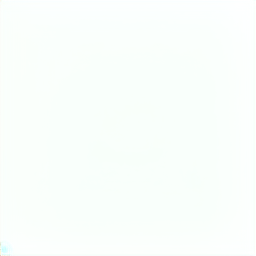

In [22]:
custom_to_pil(np.asarray(get_images(jnp.expand_dims(greedy_output[0][0],0), model)[0]))